##### XGBoost Train

In [13]:
import pandas as pd
import numpy as np 
import ccxt 
from tqdm import tqdm 
import seaborn as sns 
from xgboost import XGBClassifier
import pandas_ta as ta
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import f1_score

In [108]:
chart_df = pd.read_csv("chart_with_sentiments.csv")

chart_df

,open,high,low,close,volume,datetime,positives,negatives
0,4261.48,4349.99,4261.32,4349.99,82.088865,2017-08-17 04:00:00,0.000000,0.000000
1,4333.32,4485.39,4333.32,4427.30,63.619882,2017-08-17 08:00:00,0.000000,0.000000
2,4436.06,4485.39,4333.42,4352.34,174.562001,2017-08-17 12:00:00,0.000000,0.000000
3,4352.33,4354.84,4200.74,4325.23,225.109716,2017-08-17 16:00:00,0.000000,0.000000
4,4307.56,4369.69,4258.56,4285.08,249.769913,2017-08-17 20:00:00,0.000000,0.000000
...,...,...,...,...,...,...,...,...
11847,20735.69,20759.00,20573.13,20722.23,28650.057260,2023-01-15 08:00:00,0.693678,0.306322
11848,20722.23,20994.05,20652.24,20908.28,32504.508940,2023-01-15 12:00:00,0.507753,0.492247
11849,20906.97,21050.74,20665.00,20870.15,37663.667460,2023-01-15 16:00:00,0.537020,0.462980
11850,20870.15,20952.37,20746.39,20871.50,21411.124930,2023-01-15 20:00:00,0.537020,0.462980


In [109]:
# get datetime features
months, days, hours = [], [], [] 
datetime_values = chart_df["datetime"].values 
for i in range(len(datetime_values)): 
    dtobj = pd.to_datetime(datetime_values[i]) 
    months.append(dtobj.month) 
    days.append(dtobj.day) 
    hours.append(dtobj.hour) 
    
chart_df["months"] = months 
chart_df["days"] = days 
chart_df["hours"] = hours

# construct targets
high = chart_df["high"].values 
low = chart_df["low"].values 
close = chart_df["close"].values 

targets = [] 

for i in range(len(close)-1): 
    high_vol = (high[i+1] - close[i]) / close[i] 
    low_vol = (low[i+1] - close[i]) / close[i] 
    if high_vol >= 0.0075: 
        targets.append(0) 
    elif low_vol <= -0.0075: 
        targets.append(1) 
    else: 
        targets.append(2) 
targets.append(None) 

chart_df["targets"] = targets 

# feature engineering 
chart_df.set_index(pd.DatetimeIndex(chart_df["datetime"]), inplace=True)

chart_df["bop"] = chart_df.ta.bop(lookahead=False) 
chart_df["ebsw"] = chart_df.ta.ebsw(lookahead=False) 
chart_df["cmf"] = chart_df.ta.cmf(lookahead=False) 
chart_df["vwap"] = chart_df.ta.vwap(lookahead=False) 
chart_df["rsi/100"] = chart_df.ta.rsi(lookahead=False) / 100 
chart_df["high/low"] = chart_df["high"] / chart_df["low"] 
chart_df["close/open"] = chart_df["close"] / chart_df["open"] 
chart_df["high/open"] = chart_df["high"] / chart_df["open"] 
chart_df["low/open"] = chart_df["low"] / chart_df["open"] 
chart_df["hwma"] = chart_df.ta.hwma(lookahead=False) 
chart_df["linreg"] = chart_df.ta.linreg(lookahead=False) 
chart_df["hwma/close"] = chart_df["hwma"] / chart_df["close"] 
chart_df["linreg/close"] = chart_df["linreg"] / chart_df["close"] 

for l in tqdm(range(1, 12), position = 0, leave=True): 
    for col in ["open", "high", "low", "close", "volume", "vwap"]: 
        val = chart_df[col].values 
        val_ret = [None for _  in range(l)] 
        for i in range(l, len(val)):
            if val[i-l] == 0: 
                ret = 1 
            else: 
                ret = val[i] / val[i-l]  
            val_ret.append(ret) 
        chart_df["{}_change_{}".format(col, l)] = val_ret 
        
chart_df.drop(columns={"open", "high", "low", "close", "volume", "vwap", "hwma", "linreg", "datetime"}, inplace=True) 
chart_df.dropna(inplace=True) 

  0%|          | 0/11 [00:00<?, ?it/s]

In [110]:
chart_df.tail()

,positives,negatives,months,days,hours,targets,bop,ebsw,cmf,rsi/100,...,low_change_10,close_change_10,volume_change_10,vwap_change_10,open_change_11,high_change_11,low_change_11,close_change_11,volume_change_11,vwap_change_11
datetime,,,,,,,,,,,,,,,,,,,,,
2023-01-15 04:00:00,0.604706,0.395294,1,15,4,1.0,0.135289,0.675729,0.267520,0.788829,...,1.098629,1.076553,0.238653,1.093601,1.100616,1.090876,1.098717,1.095912,0.378044,1.099542
2023-01-15 08:00:00,0.693678,0.306322,1,15,8,0.0,-0.072416,0.096958,0.271411,0.784283,...,1.079379,1.070252,0.376537,1.087931,1.095912,1.074988,1.093645,1.075854,0.337209,1.092503
2023-01-15 12:00:00,0.507753,0.492247,1,15,12,1.0,0.544308,-0.693251,0.293178,0.801327,...,1.069191,1.049085,0.413732,1.081280,1.075854,1.081818,1.083530,1.079861,0.427194,1.089706
2023-01-15 16:00:00,0.537020,0.462980,1,15,16,2.0,-0.095453,0.158438,0.274325,0.787593,...,1.039066,0.995370,0.283385,1.003903,1.079714,1.052537,1.069851,1.047172,0.479400,1.082540
2023-01-15 20:00:00,0.537020,0.462980,1,15,20,0.0,0.006554,0.860109,0.329369,0.787731,...,0.998509,0.998763,0.479250,1.001902,1.047172,0.985623,1.043159,0.995434,0.161099,1.004317


<AxesSubplot:xlabel='targets', ylabel='count'>

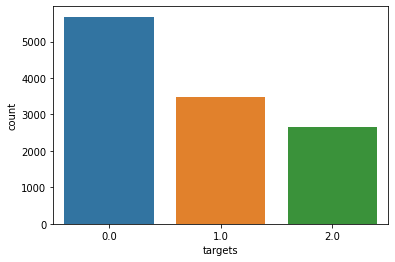

In [111]:
sns.countplot(chart_df, x = "targets")

In [112]:
train_size = int(0.8 * chart_df.shape[0]) 
val_size = int(0.1 * chart_df.shape[0]) 

train_df = chart_df.iloc[:train_size] 
val_df = chart_df.iloc[train_size:train_size+val_size] 
test_df = chart_df.iloc[train_size+val_size:] 

train_df.shape, val_df.shape, test_df.shape

((9449, 82), (1181, 82), (1182, 82))

In [113]:
train_columns = [] 
for col in chart_df.columns: 
    if col != "targets":
        train_columns.append(col) 
        
X_train = train_df[train_columns] 
Y_train = train_df["targets"] 

X_val = val_df[train_columns] 
Y_val = val_df["targets"] 

X_test = test_df[train_columns] 
Y_test = test_df["targets"] 

X_train.shape, Y_train.shape, X_val.shape, Y_val.shape, X_test.shape, Y_test.shape

((9449, 81), (9449,), (1181, 81), (1181,), (1182, 81), (1182,))

In [114]:
class_weights = compute_class_weight(class_weight = "balanced",
                                     classes = np.unique(Y_train),
                                     y = Y_train) 

d = {0:class_weights[0], 1:class_weights[1], 2:class_weights[2]} 

In [38]:
clf = XGBClassifier(silent=False, 
                    n_estimators=100,
                    class_weight=d, 
                    metric="logloss", 
                    tree_method="gpu_hist",
                    max_depth=3)

clf.fit(X_train, 
        Y_train, 
        eval_set=[(X_val, Y_val)],
        verbose=20)

[08:25:12] WARNING: ../src/learner.cc:576: 
Parameters: { "class_weight", "metric", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[08:25:12] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.05196
[20]	validation_0-mlogloss:0.96561


/opt/conda/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[40]	validation_0-mlogloss:0.97146
[60]	validation_0-mlogloss:0.97634
[80]	validation_0-mlogloss:0.98124
[99]	validation_0-mlogloss:0.98610


XGBClassifier(base_score=0.5, booster='gbtree',
              class_weight={0: 0.6677266624266837, 1: 1.13256622318111,
                            2: 1.6143857850674868},
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              enable_categorical=False, gamma=0, gpu_id=0, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=3, metric='logloss',
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1,
              objective='multi:softprob', predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=None, silent=False,
              subsample=1, tree_method='gpu_hist', ...)

In [39]:
Y_pred = clf.predict(X_test) 

gt = Y_test.values 

cnt = 0 

for i in range(len(Y_pred)): 
    if Y_pred[i] == gt[i]: 
        cnt += 1 
        
accuracy = cnt / len(Y_pred) * 100 
f1 = f1_score(gt, Y_pred, average="weighted") 

accuracy, f1

(54.90693739424704, 0.5285295506919703)

In [43]:
clf.save_model("CBITS_XGB") 

##### TabNet Train

In [72]:
from pytorch_tabnet.tab_model import TabNetClassifier 

tab_clf = TabNetClassifier(n_steps=4, verbose=20) 
tab_clf.fit(X_train.values, 
            Y_train.values, 
            eval_set=[(X_val.values, Y_val.values)], 
            eval_metric=["logloss"], 
            max_epochs = 300, 
            patience = 300, # no early stopping, 
            weights = d) 

/opt/conda/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.4614  | val_0_logloss: 1.16878 |  0:00:00s
epoch 20 | loss: 0.93064 | val_0_logloss: 1.06675 |  0:00:10s
epoch 40 | loss: 0.92094 | val_0_logloss: 1.05152 |  0:00:20s
epoch 60 | loss: 0.90968 | val_0_logloss: 1.04067 |  0:00:30s
epoch 80 | loss: 0.90393 | val_0_logloss: 1.01041 |  0:00:39s
epoch 100| loss: 0.90125 | val_0_logloss: 1.04789 |  0:00:49s
epoch 120| loss: 0.8927  | val_0_logloss: 1.00897 |  0:00:59s
epoch 140| loss: 0.88503 | val_0_logloss: 1.04062 |  0:01:09s
epoch 160| loss: 0.88589 | val_0_logloss: 1.03434 |  0:01:19s
epoch 180| loss: 0.88734 | val_0_logloss: 1.03069 |  0:01:29s
epoch 200| loss: 0.88242 | val_0_logloss: 1.04154 |  0:01:38s
epoch 220| loss: 0.86302 | val_0_logloss: 1.03255 |  0:01:48s
epoch 240| loss: 0.86634 | val_0_logloss: 1.02388 |  0:01:57s
epoch 260| loss: 0.85966 | val_0_logloss: 1.04036 |  0:02:08s
epoch 280| loss: 0.8502  | val_0_logloss: 1.05305 |  0:02:18s
Stop training because you reached max_epochs = 300 with best_epoch = 2

/opt/conda/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [73]:
Y_pred = tab_clf.predict(X_test.values) 

gt = Y_test.values 

cnt = 0 

for i in range(len(Y_pred)): 
    if Y_pred[i] == gt[i]: 
        cnt += 1 
        
accuracy = cnt / len(Y_pred) * 100 
f1 = f1_score(gt, Y_pred, average="weighted") 

accuracy, f1

(51.18443316412859, 0.4947985822514664)

In [74]:
tab_prob = tab_clf.predict_proba(X_test.values) 
xgb_prob = clf.predict_proba(X_test) 



In [75]:
avg_prob = (tab_prob + xgb_prob) / 2.0 
avg_class = np.argmax(avg_prob, axis=1) 
avg_class

array([2, 1, 2, ..., 1, 1, 0])

In [76]:
cnt = 0 
for i in range(len(avg_class)): 
    if gt[i] == avg_class[i]:
        cnt += 1 
        
accuracy = cnt / len(avg_class) 
f1 = f1_score(gt, avg_class, average="weighted") 

accuracy, f1

(0.5423011844331641, 0.5237642229149104)

##### Catboost Train

##### DNN Train

In [115]:
from sklearn.metrics import log_loss, f1_score 
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight 
import pandas as pd 
import numpy as np 
import seaborn as sns 
from tqdm.auto import tqdm 
from sklearn import preprocessing
import time 
import datetime
import torch.nn.functional as F
import torch.nn as nn
import torch
from torch.utils.data import Dataset, TensorDataset, DataLoader, RandomSampler, SequentialSampler 
from transformers import *
import matplotlib.pyplot as plt

In [128]:
class MultiSampleDropout(nn.Module):
    def __init__(self, max_dropout_rate, num_samples, classifier): 
        super(MultiSampleDropout, self).__init__() 
        self.dropout = nn.Dropout
        self.classifier = classifier 
        self.max_dropout_rate = max_dropout_rate 
        self.num_samples = num_samples
    def forward(self, out): 
        return torch.mean(torch.stack([self.classifier(self.dropout(p=rate)(out)) for _, rate in enumerate(np.linspace(0, self.max_dropout_rate, self.num_samples))], dim=0), dim=0)

class AttentivePooling(torch.nn.Module):
    def __init__(self, input_dim):
        super(AttentivePooling, self).__init__()
        self.W = nn.Linear(input_dim, 1)
    def forward(self, x):
        softmax = F.softmax
        att_w = softmax(self.W(x).squeeze(-1)).unsqueeze(-1)
        x = torch.sum(x * att_w, dim=1)
        return x


class DNN(nn.Module): 
    def __init__(self, num_classes, num_features): 
        super(DNN, self).__init__() 
        self.num_classes = num_classes 
        self.num_features = num_features
        self.batchnorm = nn.BatchNorm1d(self.num_features) 
        self.fc = nn.Linear(self.num_features, 128) 
        self.fc2 = nn.Linear(128, 64) 
        self.fc3 = nn.Linear(64, self.num_classes) 
        self.multi_dropout = MultiSampleDropout(0.2, 4, self.fc3)
        
    def forward(self, x):
        x = self.batchnorm(x) 
        x = self.fc(x) 
        x = self.fc2(x) 
        x = self.multi_dropout(x) 
        return x 

In [129]:
X_train_pt = torch.tensor(X_train.values, dtype=torch.float32) 
Y_train_pt = torch.tensor(Y_train.values, dtype=int) 

X_val_pt = torch.tensor(X_val.values, dtype=torch.float32) 
Y_val_pt = torch.tensor(Y_val.values, dtype=int) 

X_test_pt = torch.tensor(X_test.values, dtype=torch.float32)
Y_test_pt = torch.tensor(Y_test.values, dtype=int) 

In [130]:
batch_size = 32 
train_data = TensorDataset(X_train_pt, Y_train_pt) 
train_sampler = RandomSampler(train_data) 
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size) 

val_data = TensorDataset(X_val_pt, Y_val_pt) 
val_sampler = SequentialSampler(val_data) 
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size) 

test_data = TensorDataset(X_test_pt, Y_test_pt) 
test_sampler = SequentialSampler(test_data) 
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size) 

In [131]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten() 
    labels_flat = labels.flatten() 
    return np.sum(pred_flat == labels_flat) / len(labels_flat) 

device = torch.device("cuda") 
best_val_loss = 99999999
train_losses, train_accuracies, val_losses, val_accuracies = [], [], [], []
class_weights = torch.tensor(class_weights).float().to(device) 
loss_func = nn.CrossEntropyLoss(weight=class_weights) 
model = DNN(num_classes=3, num_features=X_train.shape[1])
model.to(device) 
optimizer = AdamW(model.parameters(), lr=1e-3) 
epochs = 10 
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, 
                                            num_training_steps = total_steps) 

model.zero_grad() 
for epoch_i in tqdm(range(epochs), desc="Epochs", position=0, leave=True, total=epochs): 
    train_loss, train_accuracy = 0, 0 
    model.train() 
    with tqdm(train_dataloader, unit="batch") as tepoch: 
        for step, batch in enumerate(tepoch): 
            batch = tuple(t.to(device) for t in batch) 
            b_x, b_labels = batch 
            output = model(b_x) 
            loss = loss_func(output, b_labels) 
            logits_cpu, labels_cpu = output.detach().cpu().numpy(), b_labels.detach().cpu().numpy() 
            train_accuracy += flat_accuracy(logits_cpu, labels_cpu) 
            train_loss += loss.item() 
            loss.backward() 
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) 
            optimizer.step() 
            scheduler.step() 
            model.zero_grad() 
            tepoch.set_postfix(loss=train_loss/(step+1), accuracy=100.0 * train_accuracy / (step+1)) 
            time.sleep(0.1) 
        avg_train_loss = train_loss / len(train_dataloader) 
        avg_train_accuracy = train_accuracy / len(train_dataloader) 
        train_losses.append(avg_train_loss) 
        train_accuracies.append(avg_train_accuracy) 
    val_loss, val_accuracy = 0, 0 
    model.eval() 
    for step, batch in tqdm(enumerate(val_dataloader), position=0, leave=True, total=len(val_dataloader)):
        batch = tuple(t.to(device) for t in batch) 
        b_x, b_labels = batch 
        with torch.no_grad(): 
            output = model(b_x) 
        loss = loss_func(output, b_labels) 
        val_loss += loss.item() 
        logits_cpu, labels_cpu = output.detach().cpu().numpy(), b_labels.detach().cpu().numpy() 
        val_accuracy += flat_accuracy(logits_cpu, labels_cpu) 
    avg_val_loss = val_loss / len(val_dataloader) 
    avg_val_accuracy = val_accuracy / len(val_dataloader) 
    val_losses.append(avg_val_loss) 
    val_accuracies.append(avg_val_accuracy) 
    print(f"avg train loss : {avg_train_loss} | avg train accuracy : {avg_train_accuracy} | avg val loss : {avg_val_loss} | avg val accuracy : {avg_val_accuracy}")
    
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss 
        torch.save(model.state_dict(), "DNN_chkpt.pt") 


/tmp/ipykernel_268/3892336605.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  class_weights = torch.tensor(class_weights).float().to(device)


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/296 [00:00<?, ?batch/s]

  0%|          | 0/37 [00:00<?, ?it/s]

avg train loss : 0.9627244118097666 | avg train accuracy : 0.4868735923423424 | avg val loss : 1.0191626291017275 | avg val accuracy : 0.41658900279589933


  0%|          | 0/296 [00:00<?, ?batch/s]

  0%|          | 0/37 [00:00<?, ?it/s]

avg train loss : 0.9302505701780319 | avg train accuracy : 0.5087274774774775 | avg val loss : 0.9939614067206511 | avg val accuracy : 0.45080964585274924


  0%|          | 0/296 [00:00<?, ?batch/s]

  0%|          | 0/37 [00:00<?, ?it/s]

avg train loss : 0.9193206888598364 | avg train accuracy : 0.5149798235735735 | avg val loss : 0.993248066386661 | avg val accuracy : 0.46481826654240443


  0%|          | 0/296 [00:00<?, ?batch/s]

  0%|          | 0/37 [00:00<?, ?it/s]

avg train loss : 0.9138120728972796 | avg train accuracy : 0.5194139451951951 | avg val loss : 0.9771459344271067 | avg val accuracy : 0.44979030754892824


  0%|          | 0/296 [00:00<?, ?batch/s]

  0%|          | 0/37 [00:00<?, ?it/s]

avg train loss : 0.9216425265814807 | avg train accuracy : 0.5146396396396397 | avg val loss : 0.9803588535334613 | avg val accuracy : 0.4453925908667288


  0%|          | 0/296 [00:00<?, ?batch/s]

  0%|          | 0/37 [00:00<?, ?it/s]

avg train loss : 0.9127561705740722 | avg train accuracy : 0.5196485548048049 | avg val loss : 0.9956894500835521 | avg val accuracy : 0.4437034016775396


  0%|          | 0/296 [00:00<?, ?batch/s]

  0%|          | 0/37 [00:00<?, ?it/s]

avg train loss : 0.9160235834282797 | avg train accuracy : 0.5207160285285286 | avg val loss : 0.9902594733882595 | avg val accuracy : 0.44792637465051255


  0%|          | 0/296 [00:00<?, ?batch/s]

  0%|          | 0/37 [00:00<?, ?it/s]

avg train loss : 0.9098006792970605 | avg train accuracy : 0.518041478978979 | avg val loss : 0.9894577715847943 | avg val accuracy : 0.453925908667288


  0%|          | 0/296 [00:00<?, ?batch/s]

  0%|          | 0/37 [00:00<?, ?it/s]

avg train loss : 0.9083544954254821 | avg train accuracy : 0.5227688626126127 | avg val loss : 0.9927204589586001 | avg val accuracy : 0.43703401677539605


  0%|          | 0/296 [00:00<?, ?batch/s]

  0%|          | 0/37 [00:00<?, ?it/s]

avg train loss : 0.9056839524088679 | avg train accuracy : 0.5224052177177178 | avg val loss : 0.9861056724110165 | avg val accuracy : 0.4328110438024231


In [144]:
test_model = DNN(num_classes=3, num_features=X_train.shape[1])
checkpoint = torch.load("DNN_chkpt.pt") 
test_model.load_state_dict(checkpoint) 
test_model.eval() 
test_model.to(device) 

predictions = [] 
logits = [] 

for batch in tqdm(test_dataloader): 
    batch = (t.to(device) for t in batch) 
    b_x, b_labels = batch 
    with torch.no_grad(): 
        output = test_model(b_x) 
        output = nn.Softmax()(output) 
        classes = torch.argmax(output, dim=1) 
    for i in range(len(classes)): 
        predictions.append(classes[i].detach().cpu().item()) 
        logits.append(output[i].detach().cpu().numpy()) 

  0%|          | 0/37 [00:00<?, ?it/s]

/tmp/ipykernel_268/2347588174.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output = nn.Softmax()(output)


In [145]:
gt = Y_test.values

cnt = 0

for i in range(len(gt)): 
    if gt[i] == predictions[i]: 
        cnt += 1 
        
accuray = cnt / len(predictions) 
f1 = f1_score(gt, predictions, average="weighted") 

accuracy, f1

(0.5423011844331641, 0.4862521666714149)

In [147]:
logits = np.array(logits) 
logits

array([[0.13640852, 0.23191854, 0.6316729 ],
       [0.31705412, 0.43544877, 0.24749713],
       [0.23393981, 0.34032583, 0.42573437],
       ...,
       [0.31486586, 0.36105296, 0.3240812 ],
       [0.33122894, 0.4065627 , 0.26220834],
       [0.3059556 , 0.40535522, 0.2886892 ]], dtype=float32)

In [148]:
xgb_prob

array([[0.26562855, 0.14613858, 0.5882328 ],
       [0.35263222, 0.37139103, 0.27597675],
       [0.42233625, 0.2489828 , 0.32868096],
       ...,
       [0.33861297, 0.51957715, 0.1418099 ],
       [0.45136967, 0.46095467, 0.08767569],
       [0.5155421 , 0.3371213 , 0.14733662]], dtype=float32)

In [149]:
tab_prob

array([[0.12363117, 0.16417351, 0.71219534],
       [0.33966345, 0.3294205 , 0.33091602],
       [0.23677988, 0.35692218, 0.4062979 ],
       ...,
       [0.40086564, 0.4980307 , 0.10110357],
       [0.42081636, 0.46666792, 0.11251572],
       [0.44093192, 0.42606866, 0.13299942]], dtype=float32)

In [152]:
avg_prob = (xgb_prob + logits) / 2 
avg_class = np.argmax(avg_prob, axis=1)

cnt = 0 

for i in range(len(gt)): 
    if gt[i] == avg_class[i]: 
        cnt += 1 
        
        
cnt / len(avg_prob) * 100, f1_score(gt, avg_class, average="weighted") 

(55.0761421319797, 0.534794764625418)